In [1]:
#http://archive.ics.uci.edu/ml/machine-learning-databases/00222/
import numpy as np
from scipy.stats import skew
import scipy.stats as stats
from scipy.stats import skew
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.metrics import mean_squared_error, make_scorer
from IPython.display import display
from sklearn import preprocessing


plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
#load the data and drop all the 
data= pd.read_csv('../input/bank-additional-full.csv', sep=";");
data=data.dropna(axis=0) 
data= data.replace({'education': {'basic.4y': 'basic', 'basic.6y': 'basic', 'basic.9y': 'basic'} } );

data_binary= data.replace({'y': {'yes': 1, 'no': 0} } );

In [20]:
data1= pd.read_csv('../input/bank-additional-full.csv', sep=";");
len(data1.columns)

21

In [25]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

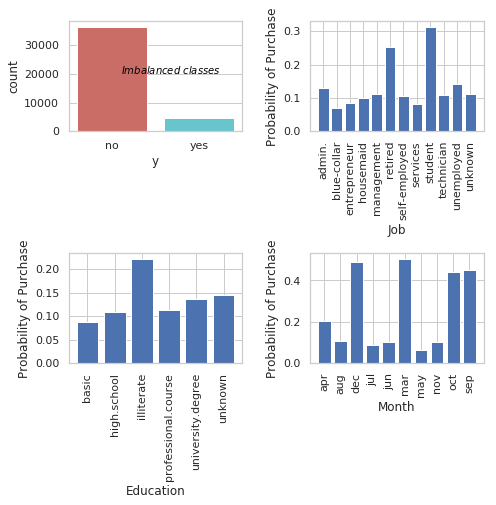

In [3]:
#Figure 1: Unitary and binary data analysis
plt.figure( figsize= [7, 7])
plt.subplot(221)
sns.countplot(x='y',data=data, palette='hls')
plt.text(0.1, 20000, r'$Imbalanced\ classes$', fontsize=10,  color=[0, 0, 0]);

plt.subplot(222)
job_call= data_binary.groupby("job").count()["y"]
job_y= data_binary.groupby("job").sum()["y"]
job_rate= job_y/job_call
plt.bar(job_y.index, job_rate)
plt.xticks(rotation=90)
#pd.crosstab(data.job,data.y).plot(kind='bar')
#plt.title('Purchase Frequency')
plt.xlabel('Job')
plt.ylabel('Probability of Purchase')

plt.subplot(223)
education_call= data_binary.groupby("education").count()["y"]
education_y= data_binary.groupby("education").sum()["y"]
education_rate= education_y/education_call
plt.bar(education_y.index, education_rate)
plt.xticks(rotation=90)
#pd.crosstab(data.education,data.y).plot(kind='bar')
#plt.title('Purchase Frequency')
plt.xlabel('Education')
plt.ylabel('Probability of Purchase')

plt.subplot(224)
month_call= data_binary.groupby("month").count()["y"]
month_y= data_binary.groupby("month").sum()["y"]
month_rate= month_y/month_call
plt.bar(month_y.index, month_rate)
plt.xticks(rotation=90)
#pd.crosstab(data.month,data.y).plot(kind='bar')
#plt.title('Purchase Frequency')
plt.xlabel('Month')
plt.ylabel('Probability of Purchase')

plt.tight_layout()
plt.savefig("../output/deposit_data-analysis.pdf", format='pdf');
plt.show()

In [4]:
data= data.replace({'y': {'yes': 1, 'no': 0} } );

In [16]:
data.groupby("y").count()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,,,,,,,,,,,
0,36548,36548,36548,36548,36548,36548,36548,36548,36548,36548,36548,36548,36548,36548,36548,36548,36548,36548,36548,36548
1,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640


In [6]:
#Data transform
#Create dummy variables.
cat_vars=[feature for feature in data.columns if data[feature].dtype=="O" ]
data_cat=data[ cat_vars].copy();
data_drop=data.drop( cat_vars, axis=1);

data_cat=pd.get_dummies(data_cat);
data_dummy=pd.concat([data_drop, data_cat], axis=1);

#Balance the two categories: y=0; y=1;
from imblearn.over_sampling import SMOTE
X= data_dummy.loc[:, data_dummy.columns !='y'];
y= data_dummy.loc[:, 'y'];

os=SMOTE(random_state=0);
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=0);

os_data_X, os_data_y= os.fit_sample(X_train, y_train);
os_data_X= pd.DataFrame( data= os_data_X, columns= X_train.columns );
os_data_y= pd.DataFrame( data= os_data_y, columns=['y'] );

X_train_rem, X_val_rem, y_train_rem, y_val_rem = train_test_split(os_data_X, os_data_y, test_size=0.3, random_state=0)

In [7]:
#Logistic Regression Model Fitting
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


logreg = LogisticRegression(solver='lbfgs' )
logreg.fit(X_train_rem, y_train_rem)

y_pred = logreg.predict(X_val_rem)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_val_rem, y_val_rem)))

/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of logistic regression classifier on test set: 0.85


/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


picked 61 features and eliminated the other 0 features


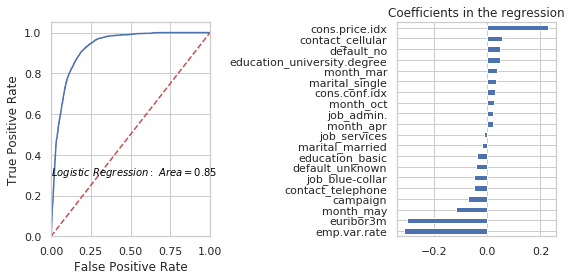

In [7]:
#Figure 2: preliminary prediction of logistic regression

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.figure( figsize= [8, 4])
plt.subplot(121)
logit_roc_auc = roc_auc_score(y_val_rem, logreg.predict(X_val_rem) )
fpr, tpr, thresholds = roc_curve(y_val_rem, logreg.predict_proba(X_val_rem)[:,1])
#plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr, tpr)
plt.text(0, 0.3, r'$Logistic\ Regression:\ Area= {:.2f}$'.format(logit_roc_auc), fontsize=10,  color=[0, 0, 0]);

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot(122)
# Plot important coefficients
coefs = pd.Series( logreg.coef_.ravel(), index =X_train_rem.columns.values)
print("picked " + str( np.sum(coefs != 0)) + " features and eliminated the other " +  \
      str(np.sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])
#imp_coefs= coefs.sort_values( ascending= False)
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the regression")
plt.tight_layout()


plt.savefig("../output/Regression_result.pdf", format='pdf');

plt.show()


In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_val_rem, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      7651
           1       0.85      0.85      0.85      7697

   micro avg       0.85      0.85      0.85     15348
   macro avg       0.85      0.85      0.85     15348
weighted avg       0.85      0.85      0.85     15348



In [37]:
# Change the labels from categorical to one-hot encoding: multiple classification

batch_size = 64
epochs = 20
num_classes = 2

train_Y_one_hot = to_categorical(y_train_rem)
val_Y_one_hot = to_categorical(y_val_rem)

# Display the change for category label using one-hot encoding
#print('Original label:', y_train_rem[0])
#print('After conversion to one-hot:', train_Y_one_hot[0])

In [29]:
X_train_rem.shape

(35810, 61)

In [28]:
X_train_rem= X_train_rem.values;
X_val_rem= X_val_rem.values;

In [59]:
#Use Neural Network to model
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical

#model.add(Dense(64))
#model.add(Activation('tanh'))
#model.add(Dense(64, activation='tanh'))

fashion_model = Sequential()
#fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(Dense(100,  input_shape=(61, ), activation="sigmoid" ) )
fashion_model.add(Dense(200, activation="sigmoid" ) )
#fashion_model.add( Activation("sigmoid") )                  
fashion_model.add(Dense(num_classes, activation='softmax') )

In [60]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, 
...        optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [61]:
fashion_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 100)               6200      
_________________________________________________________________
dense_18 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 402       
Total params: 26,802
Trainable params: 26,802
Non-trainable params: 0
_________________________________________________________________


In [62]:
fashion_train = fashion_model.fit( X_train_rem, train_Y_one_hot, batch_size=64, epochs=epochs,verbose=1,validation_data=(X_val_rem,val_Y_one_hot) )

Train on 35810 samples, validate on 15348 samples
Epoch 1/20
35810/35810 [==============================] - 1s 36us/step - loss: 0.4814 - acc: 0.7770 - val_loss: 0.4546 - val_acc: 0.7783
Epoch 2/20
35810/35810 [==============================] - 1s 26us/step - loss: 0.4505 - acc: 0.7861 - val_loss: 0.5264 - val_acc: 0.7361
Epoch 3/20
35810/35810 [==============================] - 1s 26us/step - loss: 0.3909 - acc: 0.8310 - val_loss: 0.3552 - val_acc: 0.8655
Epoch 4/20
35810/35810 [==============================] - 1s 26us/step - loss: 0.3644 - acc: 0.8494 - val_loss: 0.3468 - val_acc: 0.8586
Epoch 5/20
35810/35810 [==============================] - 1s 26us/step - loss: 0.3574 - acc: 0.8560 - val_loss: 0.3591 - val_acc: 0.8511
Epoch 6/20
35810/35810 [==============================] - 1s 25us/step - loss: 0.3587 - acc: 0.8551 - val_loss: 0.3731 - val_acc: 0.8655
Epoch 7/20
35810/35810 [==============================] - 1s 25us/step - loss: 0.3524 - acc: 0.8603 - val_loss: 0.4067 - val_acc

In [8]:
#https://www.datacamp.com/community/tutorials/decision-tree-classification-python#
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [80]:
#Building Decision Tree Model

# Create Decision Tree classifer object
clf = DecisionTreeClassifier( criterion="entropy" )
# Train Decision Tree Classifer
clf_model = clf.fit(X_train_rem, y_train_rem)

#Predict the response for test dataset
y_pred = clf.predict(X_val_rem)
#Evaluating Model: accuracy, ROC
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_val_rem, y_pred))


Accuracy: 0.9361480323169142


In [81]:
#Decision Tree is the best model in the validation process, apply it to the test data
y_test_pred = clf.predict(X_test)
#Evaluating Model: accuracy, ROC
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred))

Accuracy: 0.8921259205308731


In [82]:
#export_graphviz function converts decision tree classifier into dot file and pydotplus convert this dot file to png or displayable form on Jupyter.

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydot


export_graphviz(clf, out_file = 'tree.dot', feature_names = X_train_rem.columns, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [60]:
#Building Decision Tree Model

# Create Decision Tree classifer object
clf = DecisionTreeClassifier( criterion="entropy", max_depth=3 )
# Train Decision Tree Classifer
clf_model = clf.fit(X_train_rem, y_train_rem)
#Predict the response for test dataset
y_pred = clf_model.predict(X_val_rem)
print("Accuracy:",metrics.accuracy_score(y_val_rem, y_pred))

Accuracy: 0.8500781860828772


In [61]:
#export_graphviz function converts decision tree classifier into dot file and pydotplus convert this dot file to png or displayable form on Jupyter.

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydot
export_graphviz(clf_model, out_file = 'tree.dot', feature_names = X_train_rem.columns, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

In [62]:
X_val_rem.columns


Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',
       'day

In [63]:
# Reflection: the features

X_val_rem.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
8061,53.000000,367.000000,1.000000,999.000000,0.0,-1.800000,92.893000,-46.200000,1.354000,5099.100000,...,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
50070,48.748283,323.288329,1.000000,999.000000,0.0,-1.700000,94.027000,-38.300000,0.904000,4991.600000,...,0.0,0.0,0.000000,0.288329,0.711671,0.000000,0.0,0.0,1.0,0.0
48977,28.731444,3082.582993,1.365722,999.000000,0.0,-0.739407,93.263946,-45.026183,2.816527,5132.709838,...,0.0,0.0,0.634278,0.000000,0.000000,0.365722,0.0,0.0,1.0,0.0
29128,42.465375,246.003117,1.000000,3.462258,1.0,-3.400000,92.431000,-26.900000,0.738921,5017.500000,...,1.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,1.0
45373,29.625723,373.749839,1.374920,999.000000,0.0,-1.800000,93.559084,-36.749582,0.669496,5008.700000,...,0.0,0.0,0.625080,0.374920,0.000000,0.000000,0.0,0.0,1.0,0.0


In [75]:
#Use SVM
#As other classifiers, SVC, NuSVC and LinearSVC take as input two arrays: an array X of size [n_samples, n_features] holding the training samples, and an array y of class labels (strings or integers), size [n_samples]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
X_train_SVC= X_train_rem.to_numpy()
y_train_SVC= y_train_rem["y"].to_numpy()  #1 d array

X_val_SVC= X_val_rem.to_numpy()
y_val_SVC= y_val_rem["y"].to_numpy()


clf = SVC(kernel='linear')
clf.fit(X_train_SVC,y_train_SVC)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [76]:
y_pred = clf.predict(X_val_SVC)
print(accuracy_score(y_val_SVC, y_pred) )

0.8249934844930935


In [77]:
#SVMs decision function depends on some subset of the training data, called the support vectors. Some properties of these support vectors can be found in members support_vectors_, support_ and n_support:
# get support vectors
clf.support_vectors_

array([[2.10000000e+01, 1.80000000e+02, 3.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [5.60000000e+01, 1.46100000e+03, 2.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [5.20000000e+01, 4.02000000e+02, 2.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [2.64508224e+01, 5.77849726e+02, 1.15027414e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [3.80000000e+01, 1.09258350e+02, 1.56458739e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [3.91364456e+01, 4.73564759e+02, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [78]:
# get indices of support vectors
clf.support_

array([    6,    11,    12, ..., 35796, 35800, 35804], dtype=int32)

In [79]:
# get number of support vectors for each class
clf.n_support_ 

array([4697, 4698], dtype=int32)

In [ ]:
#1.4.1.3. Unbalanced problems
#In problems where it is desired to give more importance to certain classes or certain individual samples keywords class_weight and sample_weight can be used.

#SVC (but not NuSVC) implement a keyword class_weight in the fit method. It’s a dictionary of the form {class_label : value}, where value is a floating point number > 0 that sets the parameter C of class class_label to C * value.

In [9]:
#Random forest bagging
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
# Train the model on training data

rf.fit(X_train_rem, y_train_rem["y"] );

In [10]:
from sklearn.metrics import accuracy_score
y_pred = rf.predict(X_val_rem )
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format( accuracy_score(y_val_rem, y_pred) ) )

Accuracy of logistic regression classifier on test set: 0.95


picked 61 features and eliminated the other 0 features


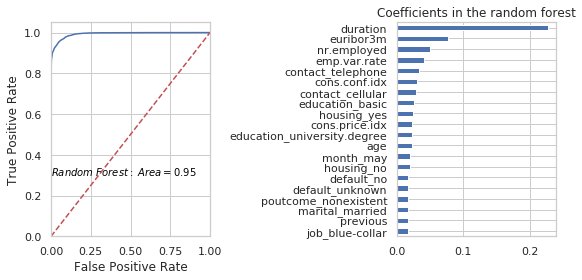

In [17]:
#Figure 2: preliminary prediction of logistic regression

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.figure( figsize= [8, 4])
plt.subplot(121)
logit_roc_auc = roc_auc_score(y_val_rem, rf.predict(X_val_rem) )
fpr, tpr, thresholds = roc_curve(y_val_rem, rf.predict_proba(X_val_rem)[:,1])
#plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr, tpr)
plt.text(0, 0.3, r'$Random\ Forest:\ Area= {:.2f}$'.format(logit_roc_auc), fontsize=10,  color=[0, 0, 0]);

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot(122)
# Plot important coefficients
coefs = pd.Series( rf.feature_importances_, index =X_train_rem.columns.values)
print("picked " + str( np.sum(coefs != 0)) + " features and eliminated the other " +  \
      str(np.sum(coefs == 0)) + " features")
#imp_coefs = pd.concat([coefs.sort_values().head(20), coefs.sort_values().tail(10)])
imp_coefs = coefs.sort_values( ascending= True).tail(20)
#imp_coefs= coefs.sort_values( ascending= False)
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the random forest")
plt.tight_layout()


plt.savefig("../output/RandomForest_result.pdf", format='pdf');

plt.show()

In [22]:
data.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [ ]:
#Improve Model if Necessary
#This is a complicated phrase that means “adjust the settings to improve performance
#hyperparameters
#The most common way to do this is simply make a bunch of models with different settings, evaluate them all on the same validation set, and see which one does best. Of course, this would be a tedious process to do by hand, and there are automated methods to do this process in Skicit-learn. 
#The question is: how does this model arrive at the values? There are two approaches to get under the hood of the random forest: first, we can look at a single tree in the forest, and second, we can look at the feature importances of our explanatory variables.

In [16]:
#Interpret Model and Report Results

# Pull out one tree from the forest
tree = rf.estimators_[5]
#export_graphviz function converts decision tree classifier into dot file and pydotplus convert this dot file to png or displayable form on Jupyter.

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydot


export_graphviz(tree, out_file = 'tree_rf.dot', feature_names = X_train_rem.columns, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree_rf.dot')
# Write graph to a png file
graph.write_png('tree_rf.png')


In [19]:
#Limit the max_depth of random forest to 3, plot a tree
#Random forest bagging
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf_small = RandomForestClassifier(n_estimators = 1000, max_depth=3)
# Train the model on training data
rf_small.fit(X_train_rem, y_train_rem["y"] );
from sklearn.metrics import accuracy_score
y_pred = rf_small.predict(X_val_rem )
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format( accuracy_score(y_val_rem, y_pred) ) )

#Interpret Model and Report Results

# Pull out one tree from the forest
tree = rf_small.estimators_[5]
#export_graphviz function converts decision tree classifier into dot file and pydotplus convert this dot file to png or displayable form on Jupyter.

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydot


export_graphviz(tree, out_file = 'tree_rf_small.dot', feature_names = X_train_rem.columns, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree_rf_small.dot')
# Write graph to a png file
graph.write_png('tree_rf_small.png')

Accuracy of logistic regression classifier on test set: 0.88


In [ ]:
#Knowing how to find the right balance between performance and cost is an essential skill for a machine learning engineer and will ultimately depend on the problem!

In [17]:
#Random forest is the best model in the validation process, apply it to the test data
y_test_pred = rf.predict(X_test)
#Evaluating Model: accuracy, ROC
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred))

Accuracy: 0.9128429230395727


picked 61 features and eliminated the other 0 features


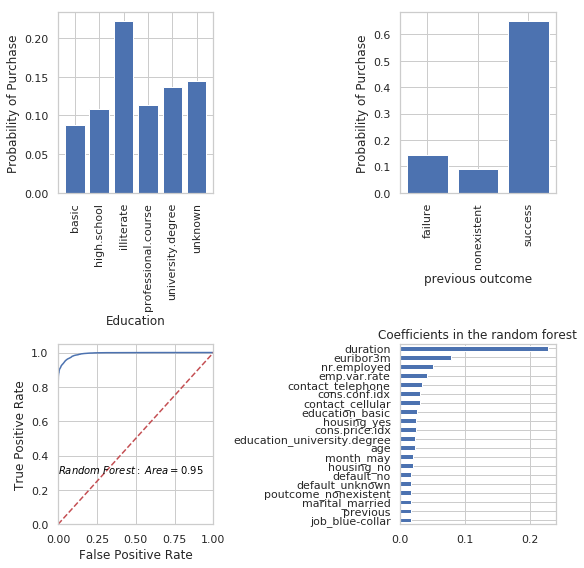

In [26]:
#Make the poster

#Figure 1: Unitary and binary data analysis
plt.figure( figsize= [8, 8])
plt.subplot(221)
education_call= data_binary.groupby("education").count()["y"]
education_y= data_binary.groupby("education").sum()["y"]
education_rate= education_y/education_call
plt.bar(education_y.index, education_rate)
plt.xticks(rotation=90)
#pd.crosstab(data.education,data.y).plot(kind='bar')
#plt.title('Purchase Frequency')
plt.xlabel('Education')
plt.ylabel('Probability of Purchase')

plt.subplot(222)
poutcome_call= data_binary.groupby("poutcome").count()["y"]
poutcome_y= data_binary.groupby("poutcome").sum()["y"]
poutcome_rate= poutcome_y/poutcome_call
plt.bar(poutcome_y.index, poutcome_rate)
plt.xticks(rotation=90)
#pd.crosstab(data.poutcome,data.y).plot(kind='bar')
#plt.title('Purchase Frequency')
plt.xlabel('previous outcome')
plt.ylabel('Probability of Purchase')

plt.subplot(223)
logit_roc_auc = roc_auc_score(y_val_rem, rf.predict(X_val_rem) )
fpr, tpr, thresholds = roc_curve(y_val_rem, rf.predict_proba(X_val_rem)[:,1])
#plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr, tpr)
plt.text(0, 0.3, r'$Random\ Forest:\ Area= {:.2f}$'.format(logit_roc_auc), fontsize=10,  color=[0, 0, 0]);

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot(224)
# Plot important coefficients
coefs = pd.Series( rf.feature_importances_, index =X_train_rem.columns.values)
print("picked " + str( np.sum(coefs != 0)) + " features and eliminated the other " +  \
      str(np.sum(coefs == 0)) + " features")
#imp_coefs = pd.concat([coefs.sort_values().head(20), coefs.sort_values().tail(10)])
imp_coefs = coefs.sort_values( ascending= True).tail(20)
#imp_coefs= coefs.sort_values( ascending= False)
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the random forest")
plt.tight_layout()


plt.savefig("../output/RandomForest_Poster.pdf", format='pdf');

plt.show()